In [181]:
from collections import namedtuple

import pandas as pd
from math import log, sqrt
from sklearn import linear_model
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt

In [183]:
%matplotlib inline

In [184]:
# configuration
USER_HOME = Path("/Users/jean.metz")
PARENT_HOME = Path(USER_HOME, "workspace", "jmetzz", "ml-laboratory")
PROJECT_HOME = Path(PARENT_HOME, "basic_ml")
DATA_HOME = Path(
    PARENT_HOME,
    "data",
    "processed",
    "king_county_house_sales",
)

In [185]:
# Load the sales dataset using Pandas
dtype_dict = {
    "bathrooms": float,
    "waterfront": int,
    "sqft_above": int,
    "sqft_living15": float,
    "grade": int,
    "yr_renovated": int,
    "price": float,
    "bedrooms": float,
    "zipcode": str,
    "long": float,
    "sqft_lot15": float,
    "sqft_living": float,
    "floors": float,
    "condition": int,
    "lat": float,
    "date": str,
    "sqft_basement": int,
    "yr_built": int,
    "id": str,
    "sqft_lot": int,
    "view": int,
}

kc_house_path = Path(DATA_HOME, "kc_house_data.csv")
sales = pd.read_csv(kc_house_path, dtype=dtype_dict)

Create new features by performing following transformation on inputs:

- Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1)
and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable
will mostly affect houses with many bedrooms.

- On the other hand, taking square root of sqft_living will decrease the separation
between big house and small house. The owner may not be exactly twice as happy
for getting a house that is twice as big.


In [186]:
sales["sqft_living_sqrt"] = sales["sqft_living"].apply(sqrt)
sales["sqft_lot_sqrt"] = sales["sqft_lot"].apply(sqrt)
sales["bedrooms_square"] = sales["bedrooms"] * sales["bedrooms"]
sales["floors_square"] = sales["floors"] * sales["floors"]

In [187]:
# learn regression weights
all_features = [
    "bedrooms",
    "bedrooms_square",
    "bathrooms",
    "sqft_living",
    "sqft_living_sqrt",
    "sqft_lot",
    "sqft_lot_sqrt",
    "floors",
    "floors_square",
    "waterfront",
    "view",
    "condition",
    "grade",
    "sqft_above",
    "sqft_basement",
    "yr_built",
    "yr_renovated",
]

model_all = linear_model.Lasso(alpha=5e2, normalize=True)
model_all.fit(sales[all_features], sales["price"])

Lasso(alpha=500.0, normalize=True)

In [188]:
# some utility functions


def get_selected_features(coefficients, feature_names):
    indexed_features = zip(range(coefficients.shape[0]), coefficients)
    return [feature_names[idx] for idx, value in indexed_features if value != 0]


def calc_rss(predictions, y_values):
    residuals = predictions - y_values
    return np.sum(residuals * residuals)  # square the res


def fit_models(training_set, features, target, schedule, validation_set=None):
    models = {}
    for l1_penalty in schedule:
        model = linear_model.Lasso(alpha=l1_penalty, normalize=True)
        model.fit(training_set[features], training_set[target])
        if validation_set is None:
            rss = None
            r2 = None
        else:
            predictions = model.predict(validation_set[features])
            rss = calc_rss(predictions, validation_set[target])  # square the res
            r2 = model.score(validation_set[features], validation_set[target])  # iduals and add them up
        models[l1_penalty] = namedtuple("output", ["model", "rss", "r2"])(model, rss, r2)
    return models

In [189]:
print(f"intercept: {model_all.intercept_}")
print(f"num iterations: {model_all.n_iter_}")
print("coefficients:")
print(list(zip(range(model_all.coef_.shape[0]), model_all.coef_)))
print(get_selected_features(model_all.coef_, all_features))

intercept: -218136.21403514117
num iterations: 17
coefficients:
[(0, 0.0), (1, 0.0), (2, 0.0), (3, 134.43931395541435), (4, 0.0), (5, 0.0), (6, 0.0), (7, 0.0), (8, 0.0), (9, 0.0), (10, 24750.00458560947), (11, 0.0), (12, 61749.10309070815), (13, 0.0), (14, 0.0), (15, -0.0), (16, 0.0)]
['sqft_living', 'view', 'grade']


Find a good L1 penalty:

- explore multiple values using a validation set

In [190]:
testing = pd.read_csv(Path(DATA_HOME, "wk3_kc_house_test_data.csv"), dtype=dtype_dict)
training = pd.read_csv(Path(DATA_HOME, "wk3_kc_house_train_data.csv"), dtype=dtype_dict)
validation = pd.read_csv(Path(DATA_HOME, "wk3_kc_house_valid_data.csv"), dtype=dtype_dict)

In [191]:
# Create the features as before

testing["sqft_living_sqrt"] = testing["sqft_living"].apply(sqrt)
testing["sqft_lot_sqrt"] = testing["sqft_lot"].apply(sqrt)
testing["bedrooms_square"] = testing["bedrooms"] * testing["bedrooms"]
testing["floors_square"] = testing["floors"] * testing["floors"]

training["sqft_living_sqrt"] = training["sqft_living"].apply(sqrt)
training["sqft_lot_sqrt"] = training["sqft_lot"].apply(sqrt)
training["bedrooms_square"] = training["bedrooms"] * training["bedrooms"]
training["floors_square"] = training["floors"] * training["floors"]

validation["sqft_living_sqrt"] = validation["sqft_living"].apply(sqrt)
validation["sqft_lot_sqrt"] = validation["sqft_lot"].apply(sqrt)
validation["bedrooms_square"] = validation["bedrooms"] * validation["bedrooms"]
validation["floors_square"] = validation["floors"] * validation["floors"]

In [192]:
models = fit_models(
    training_set=training,
    features=all_features,
    target="price",
    schedule=np.logspace(1, 7, num=13),
    validation_set=validation,
)
models

{10.0: output(model=Lasso(alpha=10.0, normalize=True), rss=398213327300135.0, r2=0.6742008721272454),
 31.622776601683793: output(model=Lasso(alpha=31.622776601683793, normalize=True), rss=399041900253346.8, r2=0.6735229733051101),
 100.0: output(model=Lasso(alpha=100.0, normalize=True), rss=429791604072559.7, r2=0.6483650340805038),
 316.22776601683796: output(model=Lasso(alpha=316.22776601683796, normalize=True), rss=463739831045121.06, r2=0.6205902159560701),
 1000.0: output(model=Lasso(alpha=1000.0, normalize=True), rss=645898733633800.8, r2=0.4715565007863123),
 3162.2776601683795: output(model=Lasso(alpha=3162.2776601683795, normalize=True), rss=1222506859427163.0, r2=-0.0001967320386435656),
 10000.0: output(model=Lasso(alpha=10000.0, normalize=True), rss=1222506859427163.0, r2=-0.0001967320386435656),
 31622.776601683792: output(model=Lasso(alpha=31622.776601683792, normalize=True), rss=1222506859427163.0, r2=-0.0001967320386435656),
 100000.0: output(model=Lasso(alpha=100000.0

In [193]:
sorted_models = sorted(models.items(), key=lambda item: item[1].rss)
for l1_penalty, output in sorted_models:
    print(f"penalty: {l1_penalty:.2f}, rss: {output.rss:.5e}")

print("")
best_run = sorted_models[0]
best_model = best_run[1].model
print(f"Best run: {best_run}")

penalty: 10.00, rss: 3.98213e+14
penalty: 31.62, rss: 3.99042e+14
penalty: 100.00, rss: 4.29792e+14
penalty: 316.23, rss: 4.63740e+14
penalty: 1000.00, rss: 6.45899e+14
penalty: 3162.28, rss: 1.22251e+15
penalty: 10000.00, rss: 1.22251e+15
penalty: 31622.78, rss: 1.22251e+15
penalty: 100000.00, rss: 1.22251e+15
penalty: 316227.77, rss: 1.22251e+15
penalty: 1000000.00, rss: 1.22251e+15
penalty: 3162277.66, rss: 1.22251e+15
penalty: 10000000.00, rss: 1.22251e+15

Best run: (10.0, output(model=Lasso(alpha=10.0, normalize=True), rss=398213327300135.0, r2=0.6742008721272454))


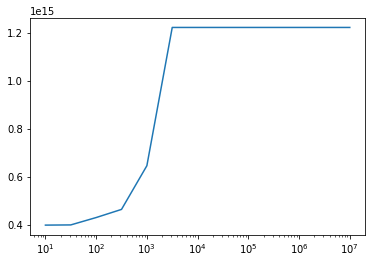

In [194]:
l1_penalties = np.array([l1_penalty for l1_penalty, _ in models.items()])
rss_array = np.array([models[penalty].rss for penalty in l1_penalties])

plt.xscale("log")
plt.plot(l1_penalties, rss_array, "-")

In [195]:
test_predictions = best_model.predict(testing[all_features])
test_rss = calc_rss(test_predictions, testing["price"])
print(f"Test set RSS: {test_rss:.5e}")

Test set RSS: 9.84674e+13


In [196]:
non_zero_weights = np.count_nonzero(best_model.coef_) + np.count_nonzero(best_model.intercept_)
print(f"# non-zero weights: {non_zero_weights}")

# non-zero weights: 15


In [197]:
best_model_features = get_selected_features(best_model.coef_, all_features)
print(
    f"Selected features number '{len(best_model_features)}' features + '{np.count_nonzero(best_model.intercept_)} intercept'"
)
print(f"Selected features are '{best_model_features}'")

Selected features number '14' features + '1 intercept'
Selected features are '['bedrooms', 'bedrooms_square', 'bathrooms', 'sqft_living', 'sqft_living_sqrt', 'sqft_lot', 'sqft_lot_sqrt', 'floors_square', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']'


In [198]:
# Two phase procedure to limit the number of features
#   - Explore a large range of ‘l1_penalty’ values to find a narrow region of ‘l1_penalty’ values
#     where models are likely to have the desired number of non-zero weights.
#   - Further explore the narrow region you found to find a good value for ‘l1_penalty’ that achieves
#     the desired sparsity.  Here, we will again use a validation set to choose the best value for ‘l1_penalty’.

max_nonzeros = 7

# Exploring large range of l1_penalty
wide_range_models = fit_models(
    training_set=training,
    features=all_features,
    target="price",
    schedule=np.logspace(1, 4, num=20),
    validation_set=validation,
)
wide_range_models

{10.0: output(model=Lasso(alpha=10.0, normalize=True), rss=398213327300135.0, r2=0.6742008721272454),
 14.38449888287663: output(model=Lasso(alpha=14.38449888287663, normalize=True), rss=396831833943813.6, r2=0.675331144018704),
 20.6913808111479: output(model=Lasso(alpha=20.6913808111479, normalize=True), rss=396210901853184.25, r2=0.675839161002884),
 29.76351441631318: output(model=Lasso(alpha=29.76351441631318, normalize=True), rss=398215534574785.94, r2=0.6741990662405337),
 42.81332398719393: output(model=Lasso(alpha=42.81332398719393, normalize=True), rss=406877258520204.75, r2=0.667112457345686),
 61.58482110660264: output(model=Lasso(alpha=61.58482110660264, normalize=True), rss=424647490490609.44, r2=0.6525737021580909),
 88.58667904100822: output(model=Lasso(alpha=88.58667904100822, normalize=True), rss=427906308934484.8, r2=0.6499074925309328),
 127.42749857031335: output(model=Lasso(alpha=127.42749857031335, normalize=True), rss=435374677102680.6, r2=0.6437972303447631),
 

In [199]:
non_zero_weights = [
    (l1, np.count_nonzero(output.model.coef_) + np.count_nonzero(output.model.intercept_))
    for l1, output in wide_range_models.items()
]
non_zero_weights

[(10.0, 15),
 (14.38449888287663, 15),
 (20.6913808111479, 15),
 (29.76351441631318, 15),
 (42.81332398719393, 13),
 (61.58482110660264, 12),
 (88.58667904100822, 11),
 (127.42749857031335, 10),
 (183.29807108324357, 7),
 (263.6650898730358, 6),
 (379.26901907322497, 6),
 (545.5594781168514, 6),
 (784.7599703514607, 5),
 (1128.8378916846884, 3),
 (1623.776739188721, 3),
 (2335.7214690901214, 2),
 (3359.818286283781, 1),
 (4832.930238571752, 1),
 (6951.927961775606, 1),
 (10000.0, 1)]

Out of this large range, we want to find the two ends of our desired narrow range of l1_penalty.
At one end, we will have l1_penalty values that have too few non-zeros, and at the other end,
we will have an l1_penalty that has too many non-zeros.

More formally, find:

- The largest l1_penalty that has more non-zeros than ‘max_nonzeros’
(if we pick a penalty smaller than this value, we will definitely have too many
non-zero weights) Store this value in the variable ‘l1_penalty_min’ (we will use it later)
- The smallest l1_penalty that has fewer non-zeros than ‘max_nonzeros’
(if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
 Store this value in the variable ‘l1_penalty_max’ (we will use it later)

In [206]:
l1_penalty_min = np.array([l1_penalty for l1_penalty, non_zeros in non_zero_weights if non_zeros > max_nonzeros]).max()
l1_penalty_max = np.array([l1_penalty for l1_penalty, non_zeros in non_zero_weights if non_zeros < max_nonzeros]).min()
print(f"({l1_penalty_min:.2e}, {l1_penalty_max:.2e})")

print(f"({int(l1_penalty_min)}, {int(l1_penalty_max)})")

(1.27e+02, 2.64e+02)
(127, 263)


In [201]:
narrow_range_models = fit_models(
    training_set=training,
    features=all_features,
    target="price",
    schedule=np.linspace(l1_penalty_min, l1_penalty_max, num=20),
    validation_set=validation,
)

narrow_non_zero_weights = [
    (l1, np.count_nonzero(output.model.coef_) + np.count_nonzero(output.model.intercept_))
    for l1, output in narrow_range_models.items()
]
narrow_non_zero_weights

[(127.42749857031335, 10),
 (134.5978981125619, 10),
 (141.76829765481045, 8),
 (148.938697197059, 8),
 (156.10909673930755, 7),
 (163.2794962815561, 7),
 (170.44989582380464, 7),
 (177.6202953660532, 7),
 (184.79069490830176, 7),
 (191.96109445055032, 7),
 (199.13149399279888, 7),
 (206.3018935350474, 6),
 (213.47229307729594, 6),
 (220.6426926195445, 6),
 (227.81309216179307, 6),
 (234.98349170404163, 6),
 (242.1538912462902, 6),
 (249.32429078853872, 6),
 (256.49469033078725, 6),
 (263.6650898730358, 6)]

In [207]:
min_l1_penalty = np.array(
    [l1_penalty for l1_penalty, non_zeros in narrow_non_zero_weights if non_zeros == max_nonzeros]
).min()
print(f"best l1 penalty value: {min_l1_penalty:.2f}")
print(f"best l1 penalty value: {int(min_l1_penalty)}")

best l1 penalty value: 156.11
best l1 penalty value: 156


In [203]:
best_narrow_run = narrow_range_models[min_l1_penalty]
get_selected_features(best_narrow_run.model.coef_, all_features)

['bathrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'yr_built']

In [204]:
print(
    f"Total non-zero: '{np.count_nonzero(best_narrow_run.model.coef_)}' features + '{np.count_nonzero(best_narrow_run.model.intercept_)}' intercept"
)

Total non-zero: '6' features + '1' intercept
